In [5]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import wave
import csv
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio


In [6]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [7]:
@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav=tf.squeeze(wav,axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [8]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

In [9]:
_ = tf.keras.utils.get_file('car.zip',
                        'https://github.com/Boden448/Sound/archive/main.zip',

                        cache_dir='./',
                        cache_subdir='masses',
                        extract=True)

In [10]:
df1 = pd.read_csv('./masses/Sound-main/meta/complete0.csv')
df2 = pd.read_csv('./masses/Sound-main/meta/complete1.csv')

merge_df = pd.concat([df1, df2], ignore_index=True)

merge_df.to_csv('./masses/Sound-main/meta/complete1.csv', index=False)

In [11]:
source_dir='./masses/Sound-main/datasets/crowd'
dest_dir='./masses/Sound-main/datasets/thunder'
base_data_path='./masses/Sound-main/datasets/all_audio_files'

In [ ]:
os.makedirs(base_data_path, exist_ok=True)

for root, dirs, files in os.walk(source_dir):
    for file in files:
        if file.endswith('.wav'):
            shutil.move(os.path.join(root, file), dest_dir)

for file in os.listdir(dest_dir):
    if file.endswith('.wav'):
        shutil.move(os.path.join(dest_dir, file), base_data_path)

In [12]:
pd_data = pd.read_csv('./masses/Sound-main/meta/complete1.csv')
pd_data.head()

,filename,fold,target,category,risk
0,bird0.wav,1,5,bird,low
1,bird1.wav,1,5,bird,low
2,bird10.wav,1,5,bird,low
3,bird100.wav,1,5,bird,low
4,bird1000.wav,1,5,bird,low


In [13]:
my_classes = ['barrier','bicycle','bird','cat','construction','crash','crowd','dog','garbage','hrain','lrain', 'playground','rustle','siren','start','thunder','train']
map_class_to_id = {'barrier':0,'bicycle':1,'bird':2,'cat':3,'construction':4,'crash':5,'crowd':6,'dog':7,'garbage':8,'hrain':9,'lrain':10, 'playground':11,'rustle':12,'siren':13,'start':14,'thunder':15,'train':16}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)

,filename,fold,target,category,risk
0,./masses/Sound-main/datasets/all_audio_files\b...,1,2,bird,low
1,./masses/Sound-main/datasets/all_audio_files\b...,1,2,bird,low
2,./masses/Sound-main/datasets/all_audio_files\b...,1,2,bird,low
3,./masses/Sound-main/datasets/all_audio_files\b...,1,2,bird,low
4,./masses/Sound-main/datasets/all_audio_files\b...,1,2,bird,low
5,./masses/Sound-main/datasets/all_audio_files\b...,1,2,bird,low
6,./masses/Sound-main/datasets/all_audio_files\b...,1,2,bird,low
7,./masses/Sound-main/datasets/all_audio_files\b...,1,2,bird,low
8,./masses/Sound-main/datasets/all_audio_files\b...,1,2,bird,low
9,./masses/Sound-main/datasets/all_audio_files\b...,1,2,bird,low


In [14]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [15]:
def load_wav_for_map(filename, label, fold):
    return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [16]:
def extract_embedding(wav_data, label, fold):
    ''' run YAMNet to extract embedding from the wav data '''
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [17]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(64).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(64).prefetch(tf.data.AUTOTUNE)

In [18]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float64,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='softmax'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 17)                8721      
                                                                 
Total params: 533,521
Trainable params: 533,521
Non-trainable params: 0
_________________________________________________________________


In [19]:
acc=[]
loss=[]
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])


callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=4,
                                            baseline=None,
                                            restore_best_weights=True)

In [20]:
for i in range(500):
    history = my_model.fit(train_ds,
                           epochs=1,
                           validation_data=val_ds,
                           callbacks=callback)
    
    acc.append(history.history['accuracy'])
    loss.append(history.history['loss'])
    print(i)
    

383/383 [==============================] - 256s 635ms/step - loss: 2.7946 - accuracy: 0.1216
0
383/383 [==============================] - 7s 18ms/step - loss: 2.5405 - accuracy: 0.2625
1
383/383 [==============================] - 7s 17ms/step - loss: 2.2272 - accuracy: 0.4171
2
383/383 [==============================] - 7s 18ms/step - loss: 2.0005 - accuracy: 0.4603
3
383/383 [==============================] - 7s 18ms/step - loss: 1.8413 - accuracy: 0.4659
4
383/383 [==============================] - 7s 19ms/step - loss: 1.6855 - accuracy: 0.4782
5
383/383 [==============================] - 7s 18ms/step - loss: 1.5801 - accuracy: 0.4797
6
383/383 [==============================] - 7s 18ms/step - loss: 1.4763 - accuracy: 0.4868
7
383/383 [==============================] - 7s 18ms/step - loss: 1.3968 - accuracy: 0.4881
8
383/383 [==============================] - 7s 19ms/step - loss: 1.3303 - accuracy: 0.4783
9
383/383 [==============================] - 7s 17ms/step - loss: 1.2729 - accu

383/383 [==============================] - 7s 17ms/step - loss: 0.1633 - accuracy: 0.9301
175
383/383 [==============================] - 6s 17ms/step - loss: 0.1652 - accuracy: 0.9302
176
383/383 [==============================] - 7s 18ms/step - loss: 0.1624 - accuracy: 0.9297
177
383/383 [==============================] - 7s 18ms/step - loss: 0.1656 - accuracy: 0.9304
178
383/383 [==============================] - 7s 18ms/step - loss: 0.1628 - accuracy: 0.9307
179
383/383 [==============================] - 7s 17ms/step - loss: 0.1629 - accuracy: 0.9303
180
383/383 [==============================] - 7s 17ms/step - loss: 0.1616 - accuracy: 0.9303
181
383/383 [==============================] - 7s 18ms/step - loss: 0.1616 - accuracy: 0.9305
182
383/383 [==============================] - 7s 17ms/step - loss: 0.1614 - accuracy: 0.9303
183
383/383 [==============================] - 7s 17ms/step - loss: 0.1610 - accuracy: 0.9312
184
383/383 [==============================] - 7s 17ms/step - lo

383/383 [==============================] - 6s 16ms/step - loss: 0.1333 - accuracy: 0.9376
349
383/383 [==============================] - 6s 16ms/step - loss: 0.1342 - accuracy: 0.9373
350
383/383 [==============================] - 6s 16ms/step - loss: 0.1326 - accuracy: 0.9382
351
383/383 [==============================] - 6s 16ms/step - loss: 0.1321 - accuracy: 0.9374
352
383/383 [==============================] - 6s 16ms/step - loss: 0.1328 - accuracy: 0.9383
353
383/383 [==============================] - 6s 16ms/step - loss: 0.1333 - accuracy: 0.9378
354
383/383 [==============================] - 6s 16ms/step - loss: 0.1334 - accuracy: 0.9381
355
383/383 [==============================] - 6s 15ms/step - loss: 0.1328 - accuracy: 0.9376
356
383/383 [==============================] - 6s 16ms/step - loss: 0.1345 - accuracy: 0.9375
357
383/383 [==============================] - 6s 16ms/step - loss: 0.1320 - accuracy: 0.9377
358
383/383 [==============================] - 6s 16ms/step - lo

In [21]:
a=[]

for i in acc:
    a.extend(i)

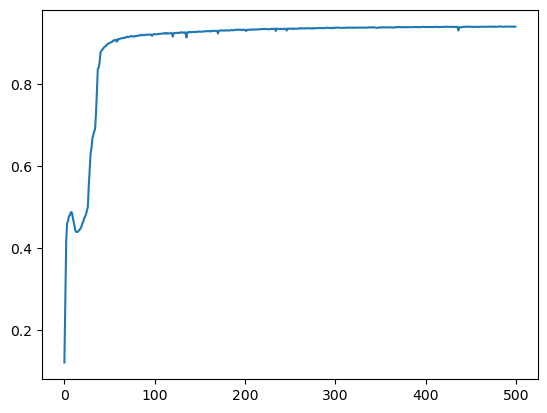

In [22]:
plt.plot(a)

In [23]:
b=[]

for i in loss:
    b.extend(i)

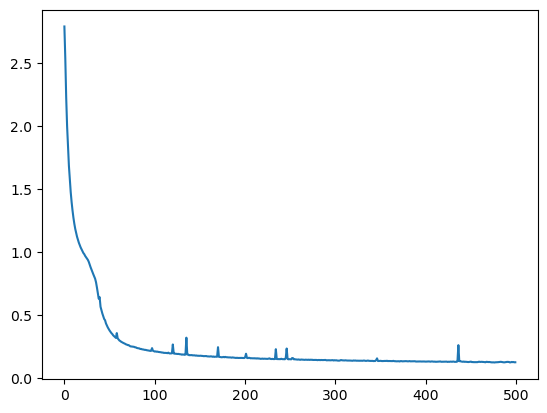

In [24]:
plt.plot(b)

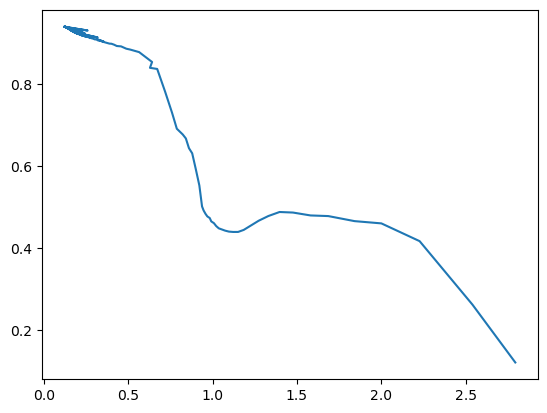

In [25]:
plt.plot(b,a)

In [28]:
with open('loss1.csv', 'w', newline='') as file:
    writer=csv.writer(file)
    writer.writerows(loss)

In [29]:
class ReduceMeanLayer(tf.keras.layers.Layer):
    def __init__(self, axis=0, **kwargs):
        super(ReduceMeanLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, input):
        return tf.math.reduce_mean(input, axis=self.axis)

In [30]:
testing_wav_file_name = tf.keras.utils.get_file('miaow_16k.wav',
                                                'https://storage.googleapis.com/audioset/miaow_16k.wav',
                                                cache_dir='./',
                                                cache_subdir='test_data')

print(testing_wav_file_name)

testing_wav_data = load_wav_16k_mono(testing_wav_file_name)

215546/215546 [==============================] - 0s 0us/step
./test_data\miaow_16k.wav


In [31]:
saved_model_path = './dogs_cos_pigs'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./dogs_cos_pigs\assets


INFO:tensorflow:Assets written to: ./dogs_cos_pigs\assets


In [32]:
reloaded_model = tf.saved_model.load(saved_model_path)

./masses/Sound-main/datasets/all_audio_files\garbage895.wav


Waveform values: [-1.05138334e-07  2.53790887e-07  1.52622320e-07 ... -2.50252755e-03
  1.01166428e-03 -5.71384095e-04]


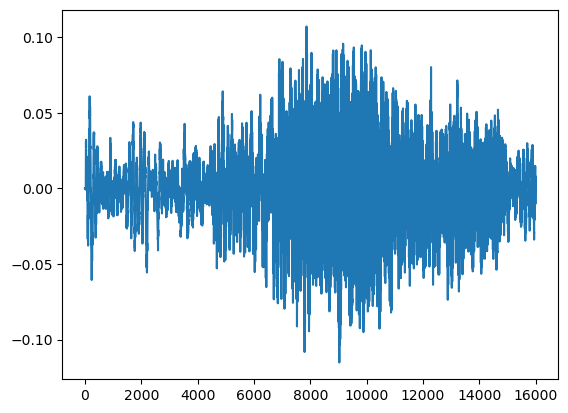

In [37]:
test_pd = filtered_pd.loc[filtered_pd['fold'] == 1]
row = test_pd.sample(1)
risk = row['risk'].item()
filename = row['filename'].item()
print(filename)
waveform = load_wav_16k_mono(filename)
print(f'Waveform values: {waveform}')
_ = plt.plot(waveform)

display.Audio(waveform, rate=16000)

In [38]:
reloaded_results = reloaded_model(waveform)
your_top_class = tf.math.argmax(reloaded_results)
your_inferred_class = my_classes[your_top_class]
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
your_top_score = class_probabilities[your_top_class]
print(f'[Your model] The main sound is: {your_inferred_class} ({your_top_score})')
print(f'risk level: {risk}')

[Your model] The main sound is: garbage (0.9999446868896484)
risk level: high
